データサイエンス特別PG データサイエンス特論 第7回 課題

In [1]:
# google colab で実行する場合は下記のコメントアウトを外して実行する
# ! wget https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx
# ! pip install japanize-matplotlib

In [2]:
import re 
import statistics
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import sklearn
from sklearn import datasets
import pandas as pd
import seaborn as sns
import openpyxl
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

print('## ライブラリのバージョンを確認')
print('matplotlib:', matplotlib.__version__)
print('numpy:', np.__version__)
print('sklearn:', sklearn.__version__)
print('pandas:', pd.__version__)
print('seaborn:', sns.__version__)

## ライブラリのバージョンを確認
matplotlib: 3.10.1
numpy: 2.1.3
sklearn: 1.6.1
pandas: 2.2.3
seaborn: 0.13.2


In [3]:
power_df = pd.read_excel('ds07_temp_power_exercise.xlsx', 
                         sheet_name='東京電力パワーグリッド エリア需給実績データ', skiprows=[0,1],
                         names=['DATE', 'TIME', 'power', '', '', '', '', '', '', '', '', '', '', '', ''])
power_df['DATETIME'] = pd.to_datetime(power_df['DATE']+' '+power_df['TIME'], format='%Y/%m/%d %H:%M')

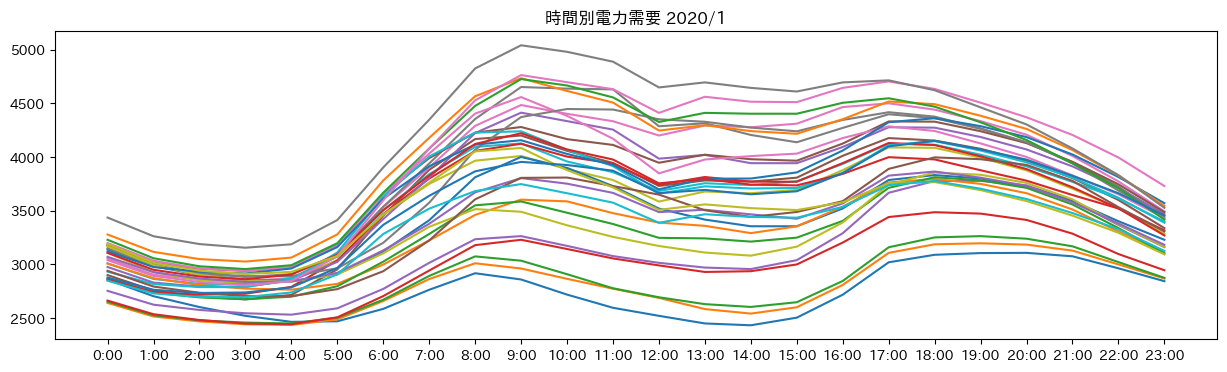

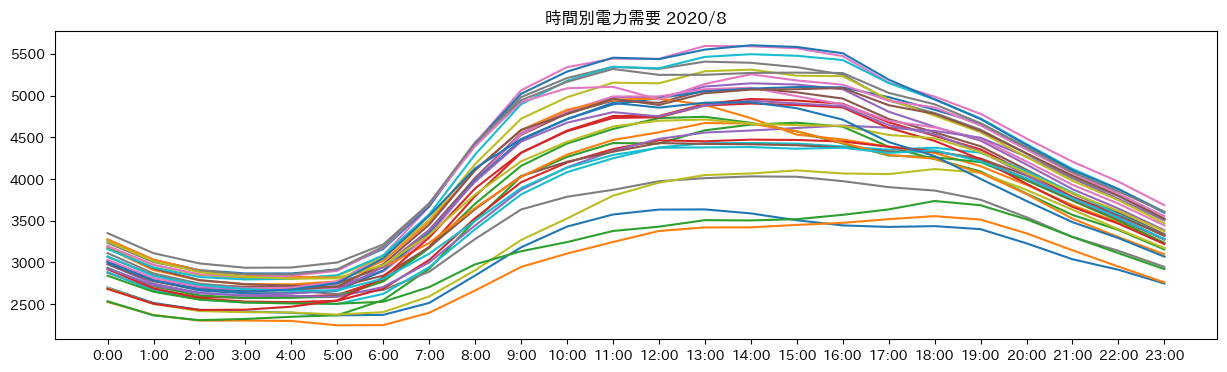

In [12]:
# 2020/1,8 の power_df の power列のデータの1日ごとの折れ線グラフを作成
fig = plt.figure(figsize=(15, 4))
for _day in range(1,32):
  plt.plot(power_df[power_df['DATE'] == f"2020/1/{_day}"]['TIME'], power_df[power_df['DATE'] == f"2020/1/{_day}"]['power'])
plt.title('時間別電力需要 2020/1')
plt.show()

fig = plt.figure(figsize=(15, 4))
for _day in range(1,32):
  plt.plot(power_df[power_df['DATE'] == f"2020/8/{_day}"]['TIME'], power_df[power_df['DATE'] == f"2020/8/{_day}"]['power'])
plt.title('時間別電力需要 2020/8')
plt.show()

In [4]:
weather_df = pd.read_excel('ds07_temp_power_exercise.xlsx', 
                           sheet_name='2020熊谷市気象データ_data', skiprows=[0,1,2],
                           names=['年月日', '平均気温', '', '', '最高気温', '', '', '', '', '最低気温', '', '', '', '', 
                           '降水量', '', '', '', '日照時間', '', '', '', '降雪量', '', '', '', '平均風速', '', '', 
                           '平均蒸気圧', '', '', '平均湿度', '', '', '平均現地気圧', '', '', '', '', '', '天気概況', '', ''])

In [5]:
def temp_power_r(weather_df, power_df, year, month, _temp):
    print(f'## {year}年{month}月の{_temp}と電力需要の単回帰・多項式回帰分析')
    # 終端の年末になる場合の処理
    if month == 12:
        end_year = year + 1
        end_month = 1
    else:
        end_year = year
        end_month = month + 1

    # 対象期間・対象の気温の独立変数と応答変数を用意
    x = weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
            & (weather_df['年月日'] < datetime.datetime(end_year,end_month,1))][[_temp]]
    y = power_df[(datetime.datetime(year,month,1) <= power_df['DATETIME'])
            & (power_df['DATETIME'] < datetime.datetime(end_year,end_month,1))
            & (power_df['TIME'] == '14:00')][['power']]
    pf = PolynomialFeatures(degree=2)
    x2 = pf.fit_transform(x)
    
    # 単回帰分析を実施して結果を出力
    model_lr = LinearRegression()
    model_lr.fit(x, y)
    legend_lr = f'y=({model_lr.intercept_[0]:.4f})+({model_lr.coef_[0][0]:.4f})x ' \
               +f'(R^2={model_lr.score(x, y):.4f})'
    print(legend_lr)

    # 多項式回帰分析を実施して結果を出力
    model_pr = LinearRegression()
    model_pr.fit(x2, y)
    legend_pr = f'y=({model_pr.intercept_[0]:.4f})+({model_pr.coef_[0][1]:.4f})x+' \
               +f'({model_pr.coef_[0][2]:.4f})x^2 (R^2={model_pr.score(x2, y):.4f})'
    print(legend_pr)

    # 元データの散布図を作成
    fig = plt.figure(figsize=(8, 7))
    ax1 = fig.add_subplot(111)
    ax1.plot(x, y, 'o')

    # 求めた単回帰分析の結果(直線)を描画
    x_linspace = pd.DataFrame(np.linspace(x.min(), x.max(), 100), columns=[_temp])
    ax1.plot(x_linspace, model_lr.predict(x_linspace), label=legend_lr)

    # 多項式回帰分析の結果(曲線)を描画
    x_linspace_pf = pf.fit_transform(x_linspace)
    y_pred = model_pr.predict(x_linspace_pf)
    ax1.plot(x_linspace, y_pred, label=legend_pr)
    ax1.set_title(f'{year}年{month}月の{_temp}と電力需要')
    ax1.legend(loc='upper left')
    plt.show()

    return model_lr.score(x, y), model_pr.score(x2, y)

In [6]:
def temp_power_r_2(weather_df, power_df, year, month, _time, _temp):
    print(f'## {year}年{month}月の{_temp}と電力需要({_time})の単回帰・多項式回帰分析')
    # 終端の年末になる場合の処理
    if month == 12:
        end_year = year + 1
        end_month = 1
    else:
        end_year = year
        end_month = month + 1

    # 対象期間・対象の気温の独立変数と応答変数を用意
    x = weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
            & (weather_df['年月日'] < datetime.datetime(end_year,end_month,1))][[_temp]]
    if re.match(r'\d:\d\d', _time):
        y = power_df[(datetime.datetime(year,month,1) <= power_df['DATETIME'])
                & (power_df['DATETIME'] < datetime.datetime(end_year,end_month,1))
                & (power_df['TIME'] == _time)][['power']]
    elif _time == 'sum':
        y = power_df[(datetime.datetime(year,month,1) <= power_df['DATETIME'])
                & (power_df['DATETIME'] < datetime.datetime(end_year,end_month,1))].groupby('DATE').sum()[['power']]
    elif _time == 'max':
        y = power_df[(datetime.datetime(year,month,1) <= power_df['DATETIME'])
                & (power_df['DATETIME'] < datetime.datetime(end_year,end_month,1))].groupby('DATE').max()[['power']]
    pf = PolynomialFeatures(degree=2)
    x2 = pf.fit_transform(x)
    
    # 単回帰分析を実施して結果を出力
    model_lr = LinearRegression()
    model_lr.fit(x, y)
    legend_lr = f'y=({model_lr.intercept_[0]:.4f})+({model_lr.coef_[0][0]:.4f})x ' \
               +f'(R^2={model_lr.score(x, y):.4f})'
    print(legend_lr)
    
    # 多項式回帰分析を実施して結果を出力
    model_pr = LinearRegression()
    model_pr.fit(x2, y)
    legend_pr = f'y=({model_pr.intercept_[0]:.4f})+({model_pr.coef_[0][1]:.4f})x+' \
               +f'({model_pr.coef_[0][2]:.4f})x^2 (R^2={model_pr.score(x2, y):.4f})'
    print(legend_pr)

    # 元データの散布図を作成
    fig = plt.figure(figsize=(8, 7))
    ax1 = fig.add_subplot(111)
    ax1.plot(x, y, 'o')

    # 求めた単回帰分析の結果(直線)を描画
    x_linspace = pd.DataFrame(np.linspace(x.min(), x.max(), 100), columns=[_temp])
    ax1.plot(x_linspace, model_lr.predict(x_linspace), label=legend_lr)

    # 多項式回帰分析の結果(曲線)を描画
    x_linspace_pf = pf.fit_transform(x_linspace)
    y_pred = model_pr.predict(x_linspace_pf)
    ax1.plot(x_linspace, y_pred, label=legend_pr)
    ax1.set_title(f'{year}年{month}月の{_temp}と電力需要({_time})')
    ax1.legend(loc='upper left')
    plt.show()

    return model_lr.score(x, y), model_pr.score(x2, y)

## 2020年8月の最高気温と電力需要の単回帰・多項式回帰分析
y=(-839.5739)+(157.2143)x (R^2=0.3234)
y=(-49727.4875)+(2938.6441)x+(-39.4226)x^2 (R^2=0.4360)


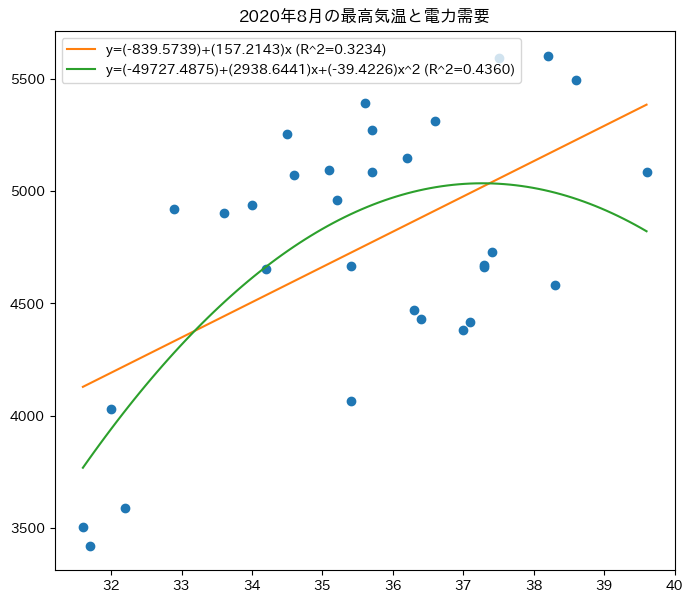

(0.3233540219227702, 0.43601726747222824)

In [7]:
temp_power_r(weather_df, power_df, 2020, 8, '最高気温')

## 2020年1月の最高気温と電力需要(max)の単回帰・多項式回帰分析
y=(3478.4202)+(55.9538)x (R^2=0.1388)
y=(3632.8308)+(28.6680)x+(1.1247)x^2 (R^2=0.1398)


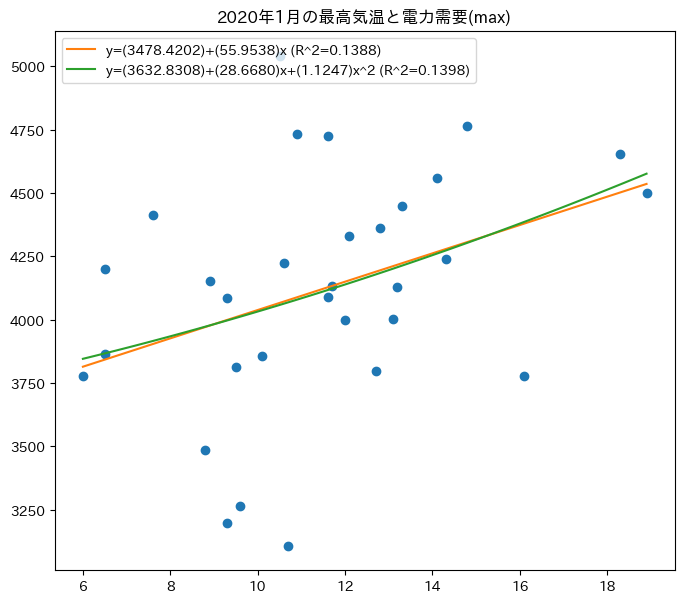

(0.13875960379671592, 0.13976098464010323)

In [8]:
temp_power_r_2(weather_df, power_df, 2020, 1, 'max', '最高気温')

## 2020年1月の最高気温と電力需要の単回帰・多項式回帰分析
y=(4459.5593)+(-72.0887)x (R^2=0.1545)
y=(6608.7040)+(-451.8630)x+(15.6541)x^2 (R^2=0.2847)


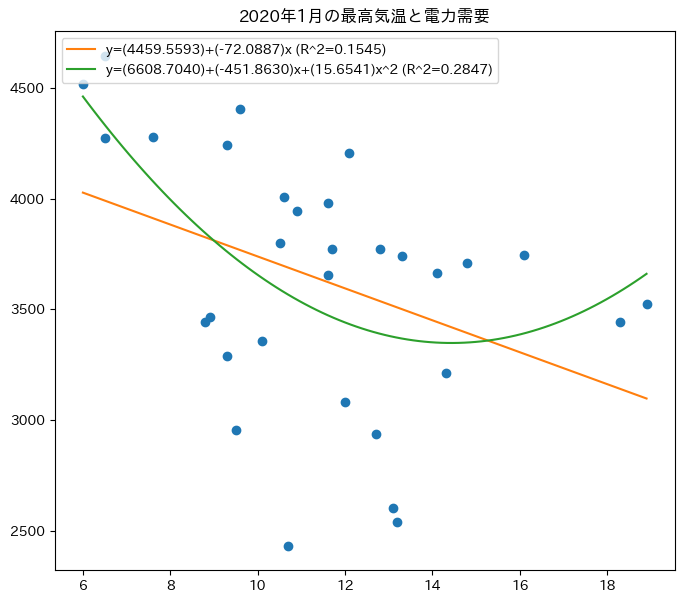

## 2020年2月の最高気温と電力需要の単回帰・多項式回帰分析
y=(4174.9381)+(-53.9811)x (R^2=0.2279)
y=(4850.8151)+(-169.8510)x+(4.6493)x^2 (R^2=0.2660)


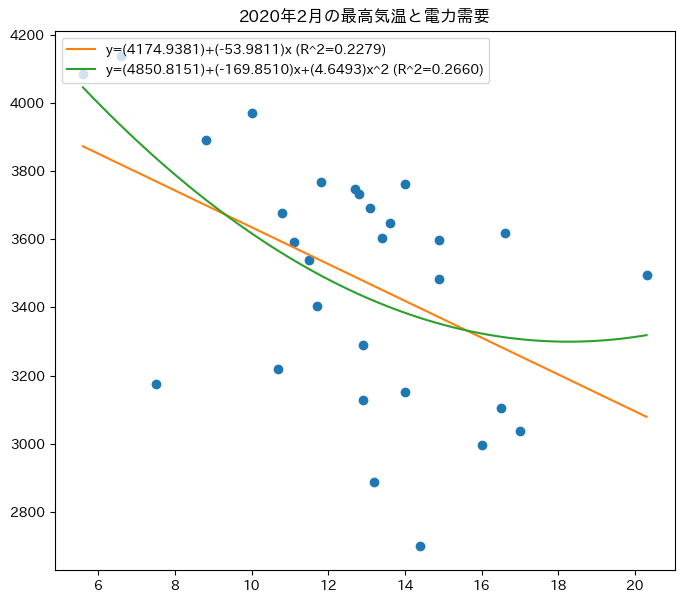

## 2020年3月の最高気温と電力需要の単回帰・多項式回帰分析
y=(4215.1068)+(-55.6737)x (R^2=0.4813)
y=(3777.4891)+(3.9191)x+(-1.8559)x^2 (R^2=0.4918)


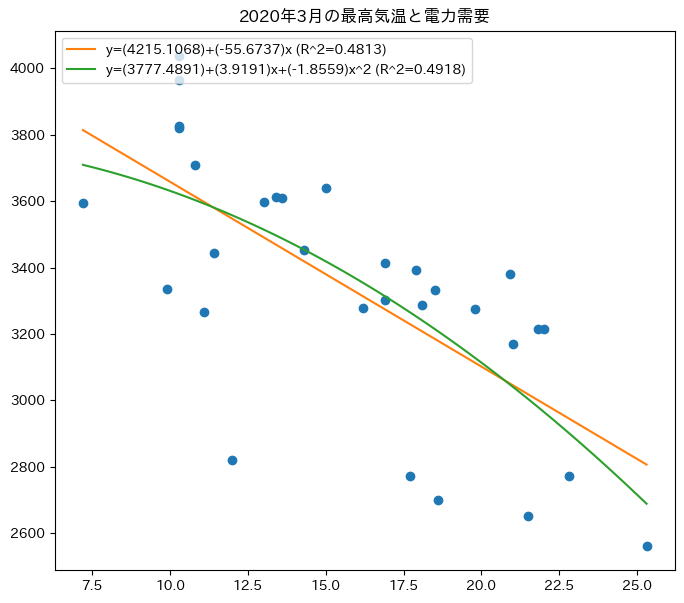

## 2020年4月の最高気温と電力需要の単回帰・多項式回帰分析
y=(4398.2696)+(-74.8142)x (R^2=0.4580)
y=(4879.6893)+(-128.7585)x+(1.4600)x^2 (R^2=0.4614)


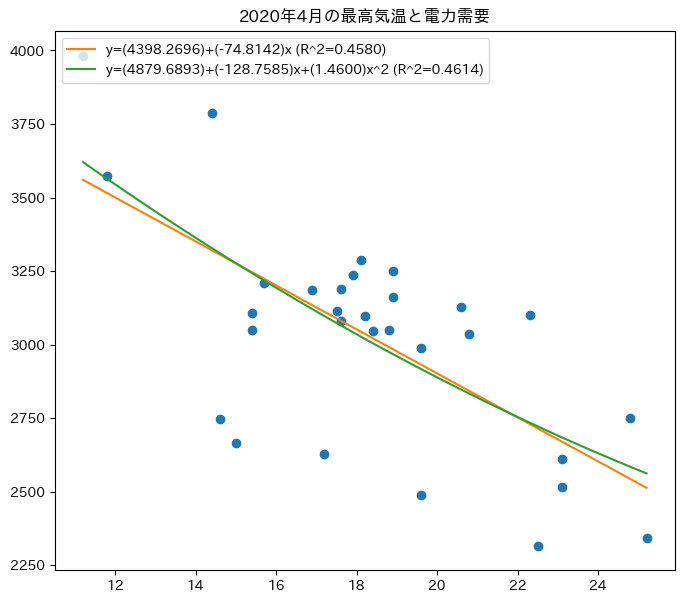

## 2020年5月の最高気温と電力需要の単回帰・多項式回帰分析
y=(2857.5222)+(-0.5074)x (R^2=0.0000)
y=(3932.1574)+(-93.6016)x+(1.9403)x^2 (R^2=0.0138)


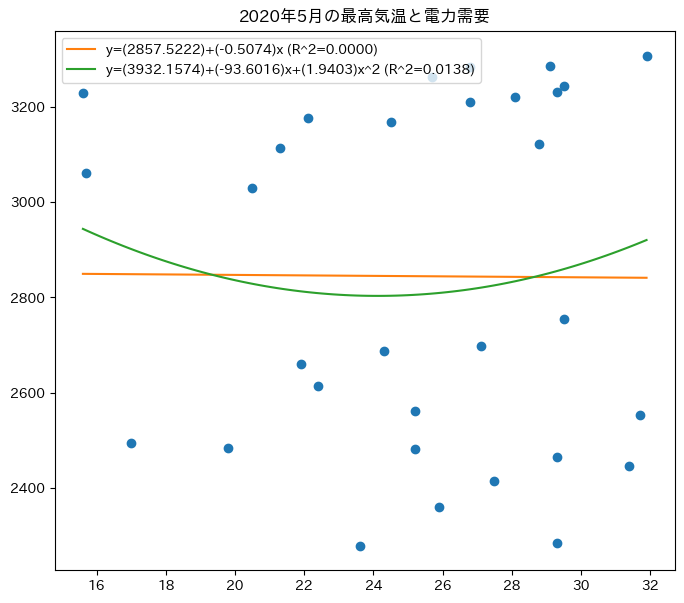

## 2020年6月の最高気温と電力需要の単回帰・多項式回帰分析
y=(1301.7292)+(78.7037)x (R^2=0.4300)
y=(7561.6541)+(-380.0967)x+(8.2309)x^2 (R^2=0.5142)


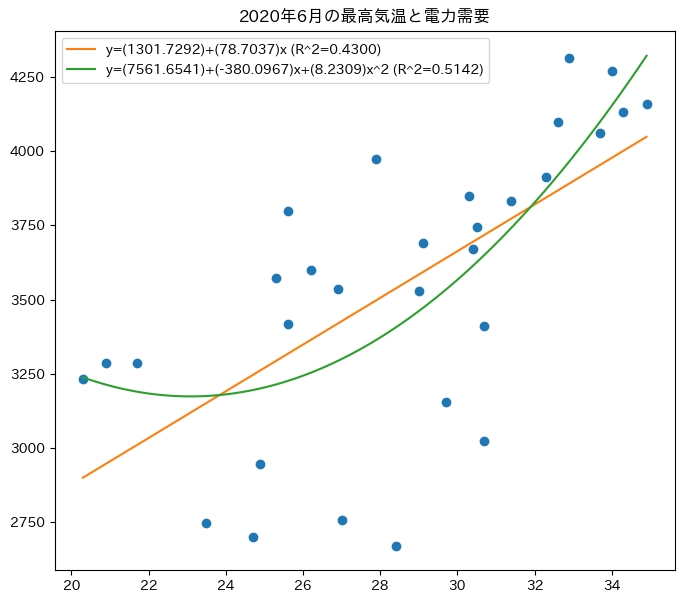

## 2020年7月の最高気温と電力需要の単回帰・多項式回帰分析
y=(1969.2834)+(62.8872)x (R^2=0.2000)
y=(-984.6440)+(274.8665)x+(-3.7584)x^2 (R^2=0.2090)


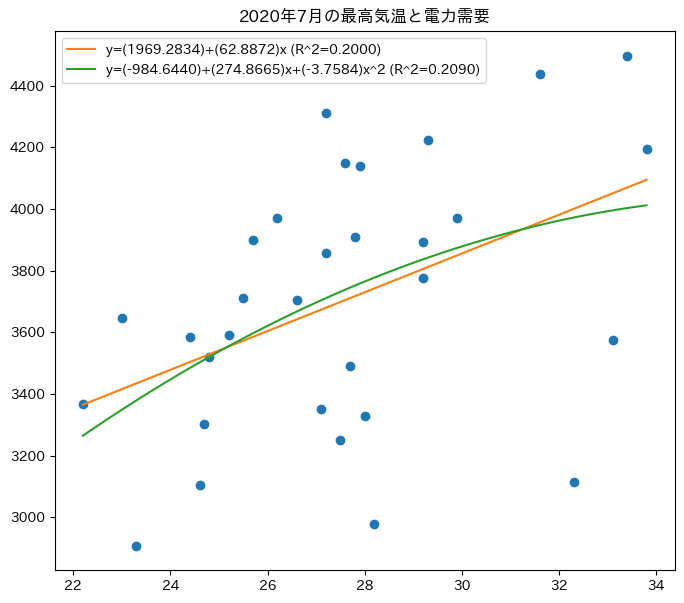

## 2020年8月の最高気温と電力需要の単回帰・多項式回帰分析
y=(-839.5739)+(157.2143)x (R^2=0.3234)
y=(-49727.4875)+(2938.6441)x+(-39.4226)x^2 (R^2=0.4360)


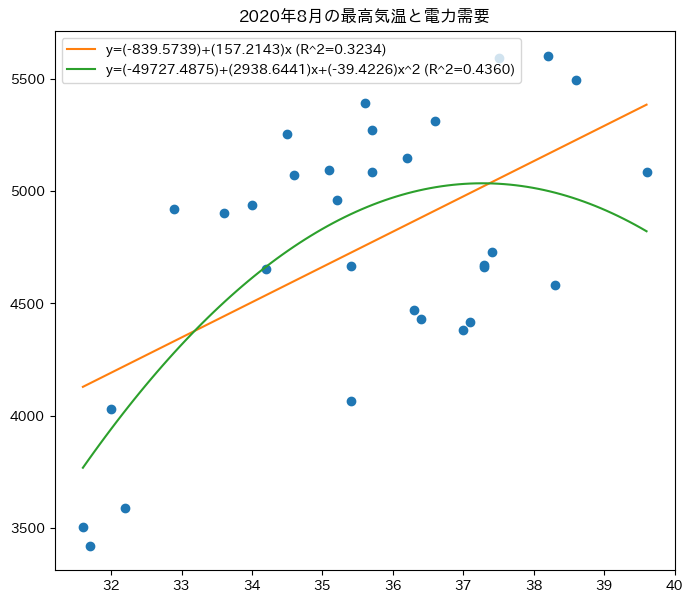

## 2020年9月の最高気温と電力需要の単回帰・多項式回帰分析
y=(-843.3622)+(167.6521)x (R^2=0.7588)
y=(5627.4898)+(-295.2823)x+(8.0945)x^2 (R^2=0.7937)


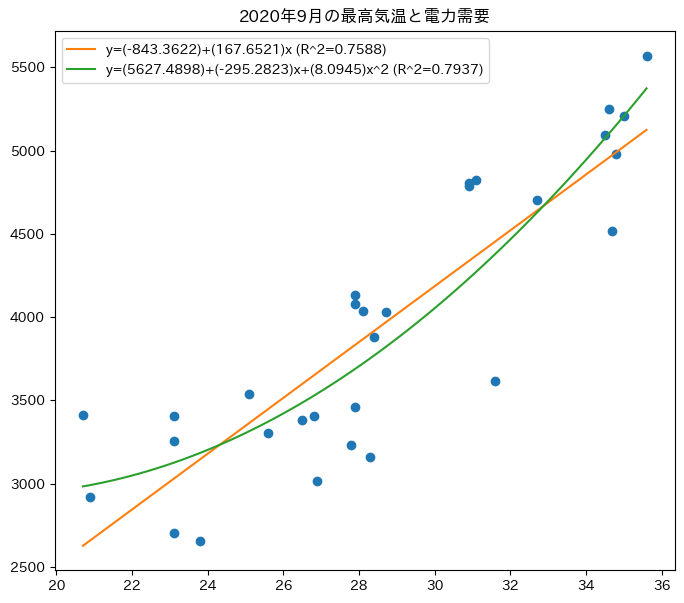

## 2020年10月の最高気温と電力需要の単回帰・多項式回帰分析
y=(3188.4018)+(0.0703)x (R^2=0.0000)
y=(6381.9898)+(-308.2425)x+(7.2435)x^2 (R^2=0.0996)


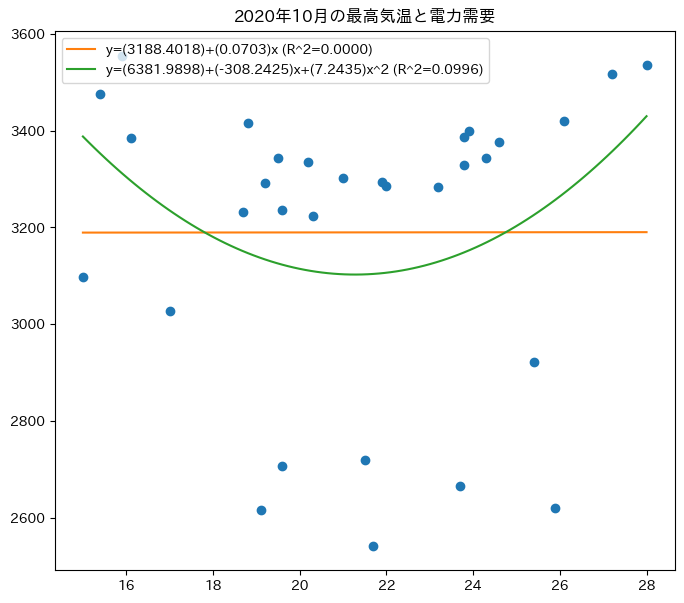

## 2020年11月の最高気温と電力需要の単回帰・多項式回帰分析
y=(4089.3955)+(-49.2967)x (R^2=0.1813)
y=(5610.5715)+(-221.0116)x+(4.7216)x^2 (R^2=0.1970)


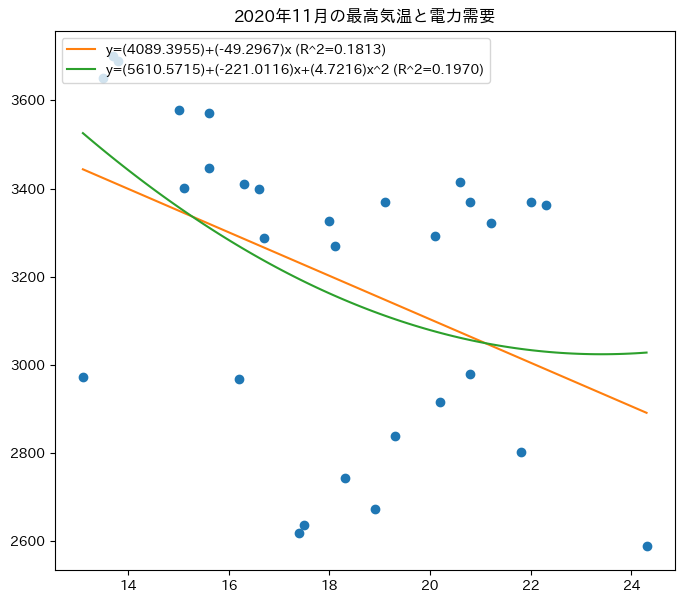

## 2020年12月の最高気温と電力需要の単回帰・多項式回帰分析
y=(4339.1798)+(-49.2539)x (R^2=0.0925)
y=(1130.3505)+(484.8872)x+(-21.3274)x^2 (R^2=0.2250)


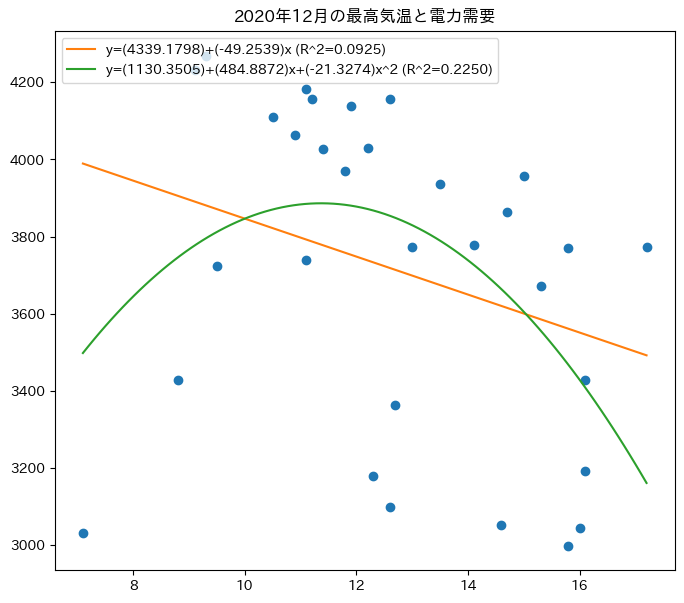

r1_min 2020/10 6.67802327103395e-07
r1_max 2020/9 0.7588076321581567
r2_min 2020/5 0.013782736934972895
r2_max 2020/9 0.7936923524932159
## 2020年1月の最低気温と電力需要の単回帰・多項式回帰分析
y=(3660.6854)+(-14.5203)x (R^2=0.0026)
y=(3655.1344)+(3.8338)x+(-3.9182)x^2 (R^2=0.0041)


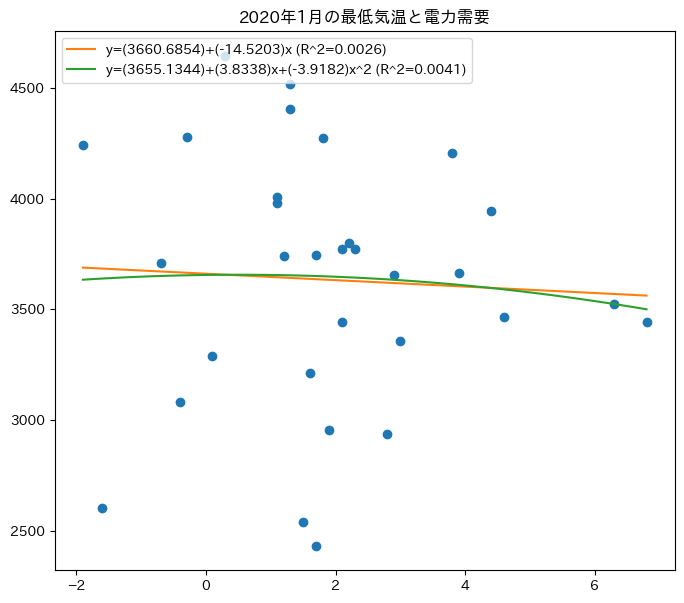

## 2020年2月の最低気温と電力需要の単回帰・多項式回帰分析
y=(3563.7334)+(-38.9818)x (R^2=0.1033)
y=(3503.3245)+(-62.6378)x+(8.6235)x^2 (R^2=0.1650)


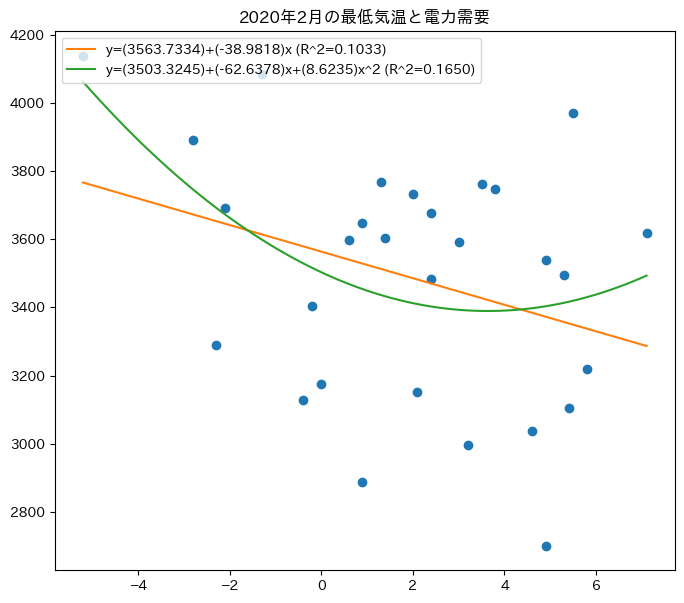

## 2020年3月の最低気温と電力需要の単回帰・多項式回帰分析
y=(3456.1278)+(-23.6975)x (R^2=0.0283)
y=(3600.2694)+(-90.7761)x+(5.9601)x^2 (R^2=0.0595)


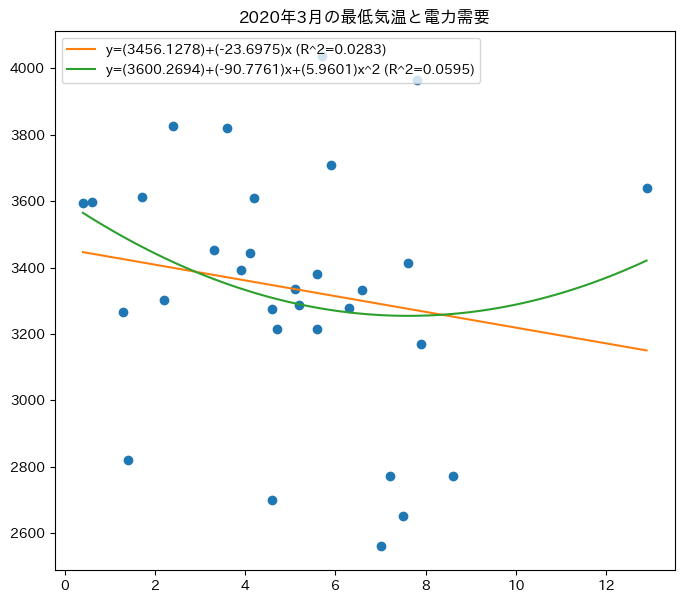

## 2020年4月の最低気温と電力需要の単回帰・多項式回帰分析
y=(2784.0488)+(32.4753)x (R^2=0.0213)
y=(2119.9696)+(225.7474)x+(-13.3010)x^2 (R^2=0.0349)


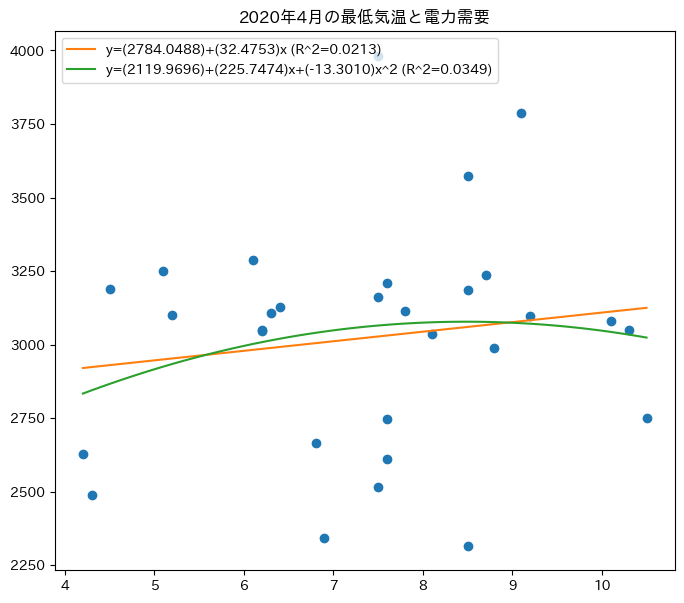

## 2020年5月の最低気温と電力需要の単回帰・多項式回帰分析
y=(2622.6617)+(15.0152)x (R^2=0.0129)
y=(5088.9960)+(-341.9464)x+(12.4403)x^2 (R^2=0.0646)


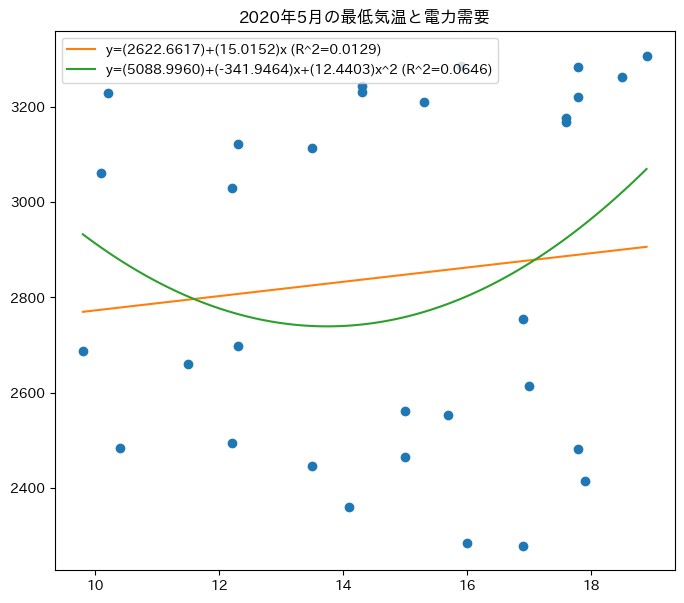

## 2020年6月の最低気温と電力需要の単回帰・多項式回帰分析
y=(508.3180)+(154.3453)x (R^2=0.2269)
y=(-14792.4591)+(1691.2911)x+(-38.3757)x^2 (R^2=0.2737)


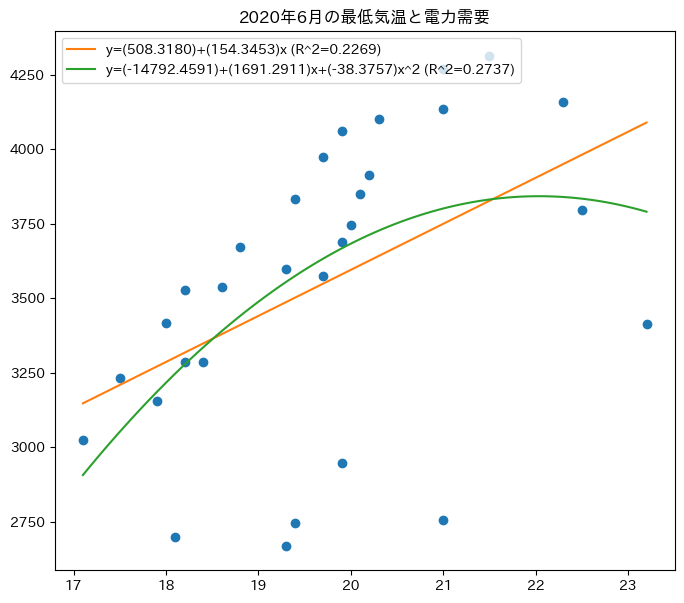

## 2020年7月の最低気温と電力需要の単回帰・多項式回帰分析
y=(1026.5798)+(125.6697)x (R^2=0.2828)
y=(11481.0433)+(-882.7018)x+(24.1309)x^2 (R^2=0.3266)


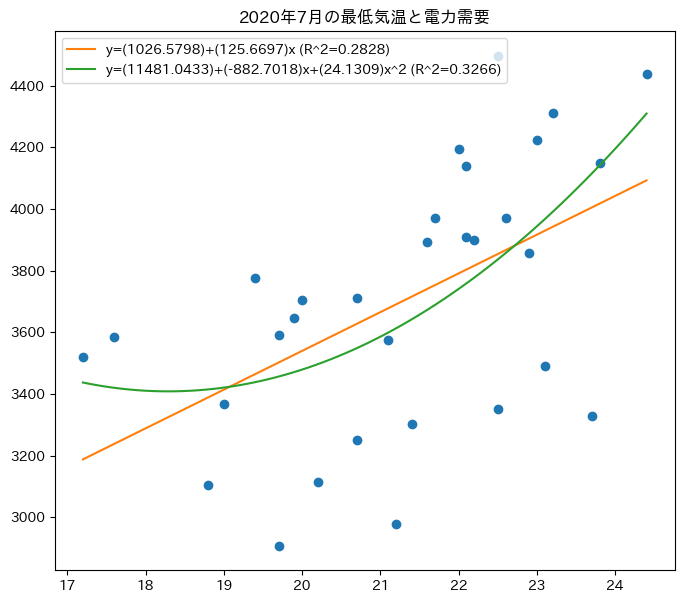

## 2020年8月の最低気温と電力需要の単回帰・多項式回帰分析
y=(910.4913)+(152.7448)x (R^2=0.1985)
y=(-35834.3540)+(3125.9383)x+(-59.8613)x^2 (R^2=0.2912)


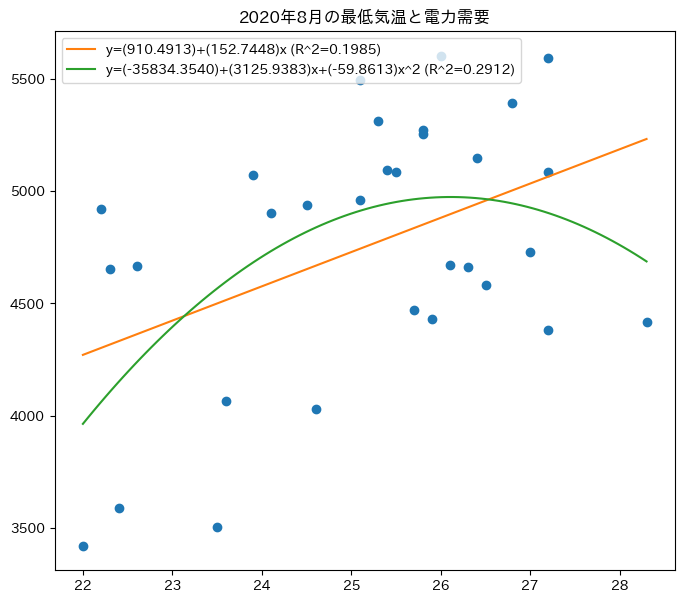

## 2020年9月の最低気温と電力需要の単回帰・多項式回帰分析
y=(-622.8439)+(216.6308)x (R^2=0.6384)
y=(10573.1564)+(-900.7711)x+(27.2464)x^2 (R^2=0.7362)


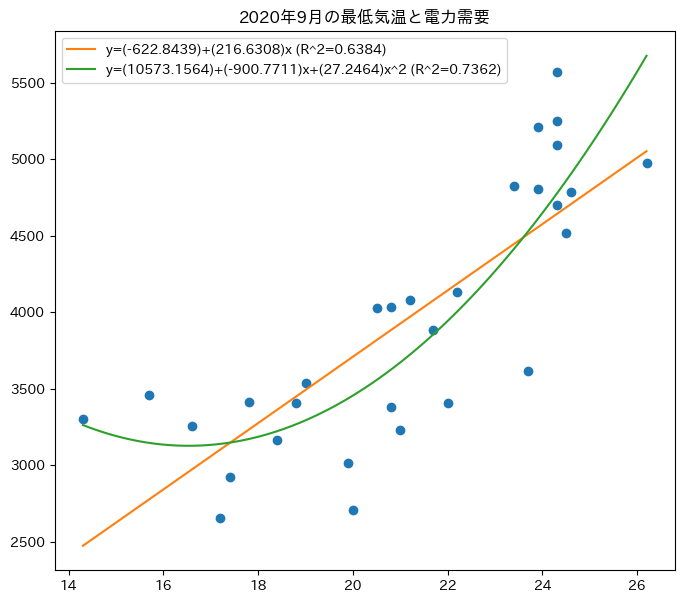

## 2020年10月の最低気温と電力需要の単回帰・多項式回帰分析
y=(2944.6763)+(17.7369)x (R^2=0.0311)
y=(869.2736)+(328.0665)x+(-11.0787)x^2 (R^2=0.1109)


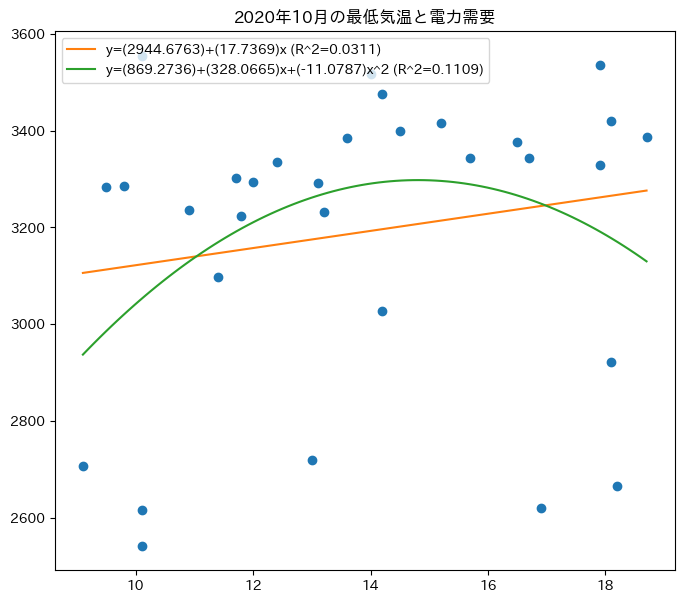

## 2020年11月の最低気温と電力需要の単回帰・多項式回帰分析
y=(3398.0450)+(-25.8363)x (R^2=0.0446)
y=(3616.6922)+(-85.8821)x+(3.6450)x^2 (R^2=0.0546)


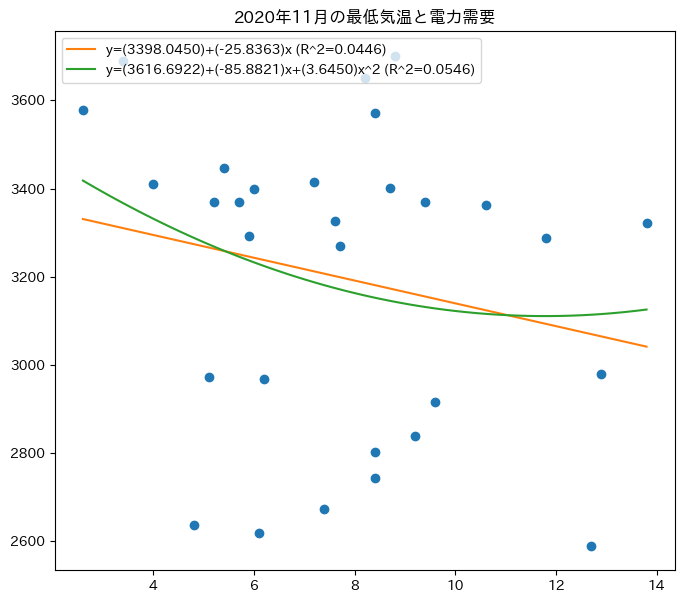

## 2020年12月の最低気温と電力需要の単回帰・多項式回帰分析
y=(3747.8935)+(-27.3412)x (R^2=0.0299)
y=(3680.6043)+(-65.9575)x+(14.0965)x^2 (R^2=0.0798)


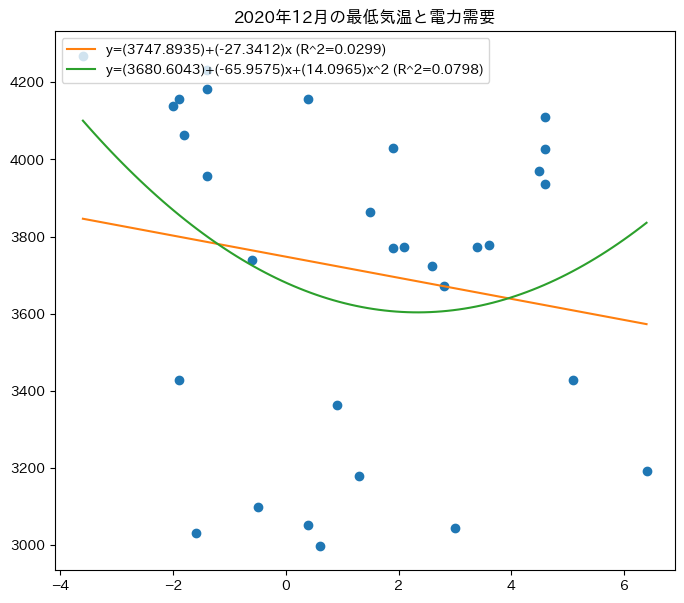

r1_min 2020/1 0.0025811994555382523
r1_max 2020/9 0.6383696658507173
r2_min 2020/1 0.004131864092257187
r2_max 2020/9 0.7361936305248549
## 2020年1月の平均気温と電力需要の単回帰・多項式回帰分析
y=(4089.8015)+(-71.5766)x (R^2=0.0660)
y=(5727.4069)+(-547.2522)x+(31.2003)x^2 (R^2=0.1752)


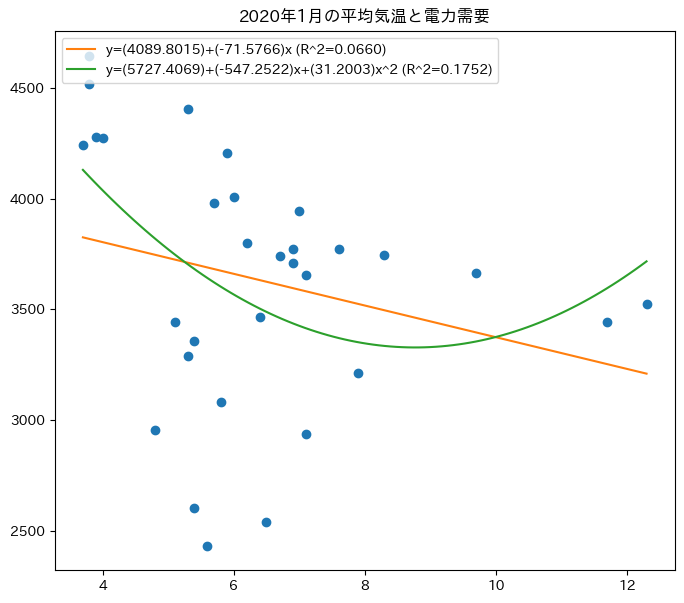

## 2020年2月の平均気温と電力需要の単回帰・多項式回帰分析
y=(3868.3782)+(-53.3058)x (R^2=0.1773)
y=(4092.6857)+(-135.7764)x+(6.1970)x^2 (R^2=0.2122)


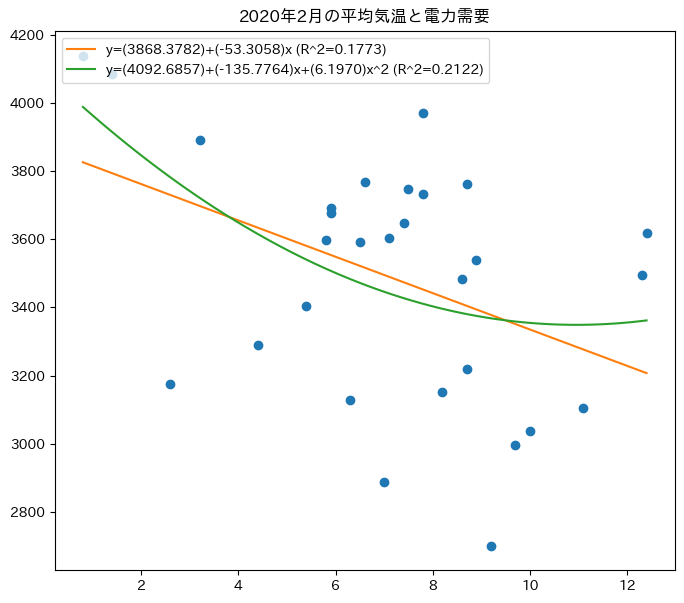

## 2020年3月の平均気温と電力需要の単回帰・多項式回帰分析
y=(4021.7444)+(-67.4264)x (R^2=0.3387)
y=(3397.5940)+(73.8955)x+(-7.1376)x^2 (R^2=0.3662)


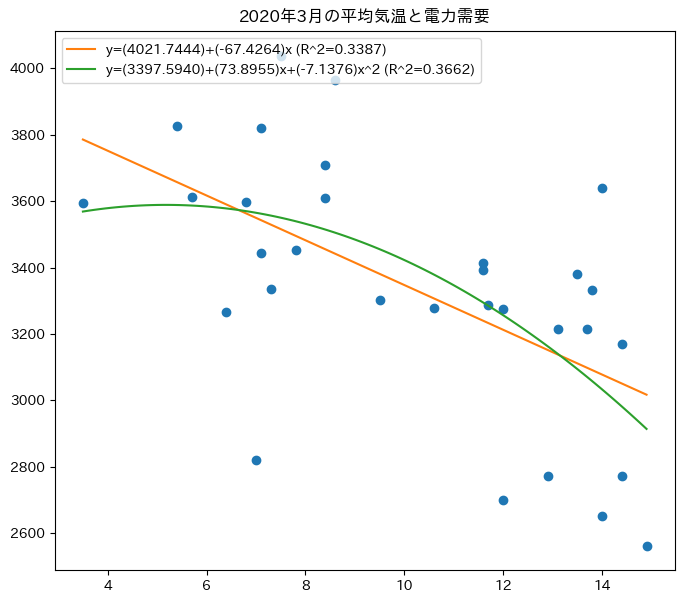

## 2020年4月の平均気温と電力需要の単回帰・多項式回帰分析
y=(4366.9711)+(-106.7881)x (R^2=0.3386)
y=(4983.3856)+(-202.2496)x+(3.5980)x^2 (R^2=0.3414)


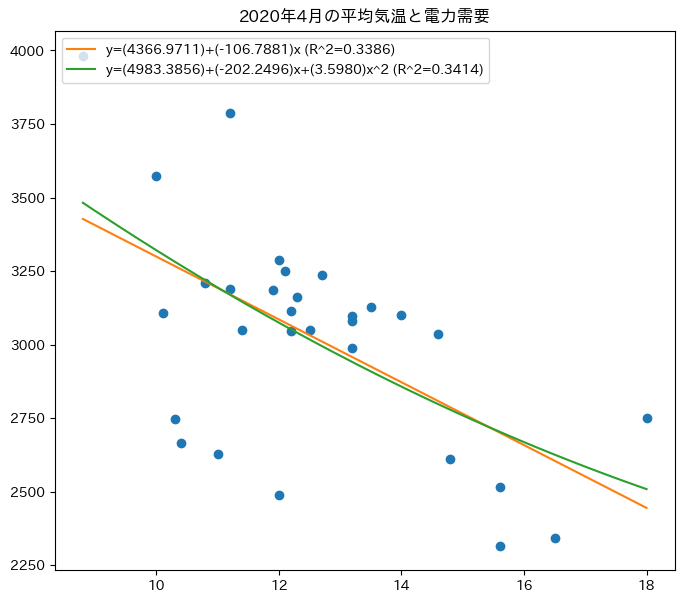

## 2020年5月の平均気温と電力需要の単回帰・多項式回帰分析
y=(2676.6504)+(8.5291)x (R^2=0.0050)
y=(6381.1259)+(-408.5788)x+(11.3653)x^2 (R^2=0.0981)


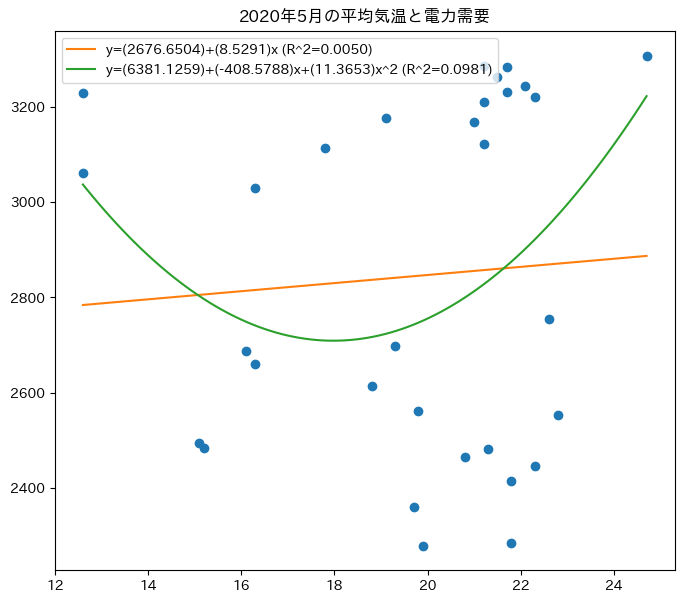

## 2020年6月の平均気温と電力需要の単回帰・多項式回帰分析
y=(237.6726)+(139.8602)x (R^2=0.4582)
y=(8167.5226)+(-541.5614)x+(14.4967)x^2 (R^2=0.4920)


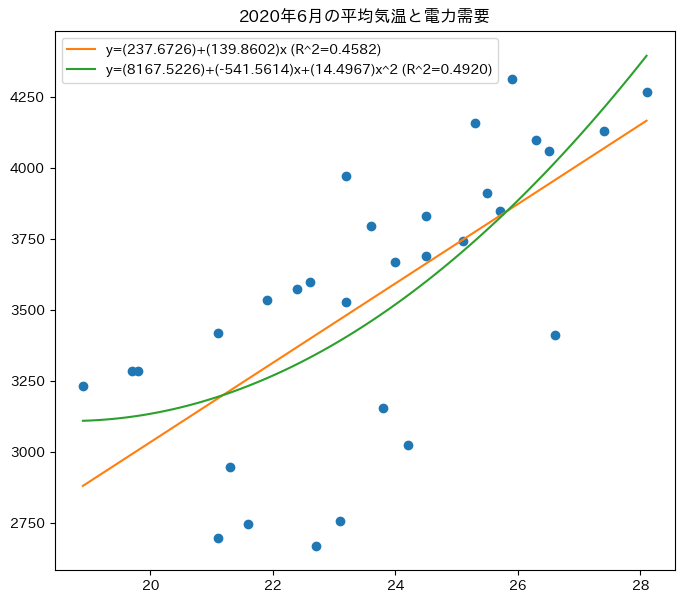

## 2020年7月の平均気温と電力需要の単回帰・多項式回帰分析
y=(755.2878)+(122.3902)x (R^2=0.3126)
y=(14156.1804)+(-1014.0741)x+(23.9327)x^2 (R^2=0.3587)


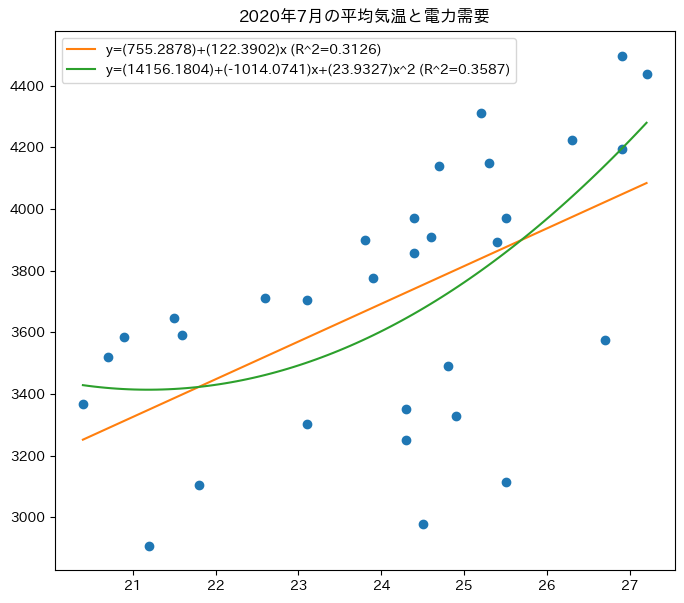

## 2020年8月の平均気温と電力需要の単回帰・多項式回帰分析
y=(-907.8119)+(191.3814)x (R^2=0.3068)
y=(-61006.9225)+(4324.0322)x+(-70.8021)x^2 (R^2=0.4461)


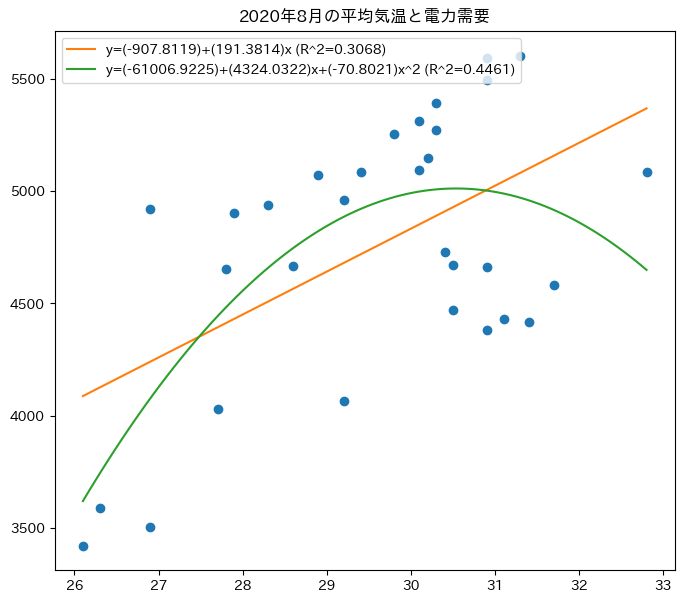

## 2020年9月の平均気温と電力需要の単回帰・多項式回帰分析
y=(-1504.4150)+(225.3127)x (R^2=0.7985)
y=(10190.4656)+(-763.1659)x+(20.5037)x^2 (R^2=0.8489)


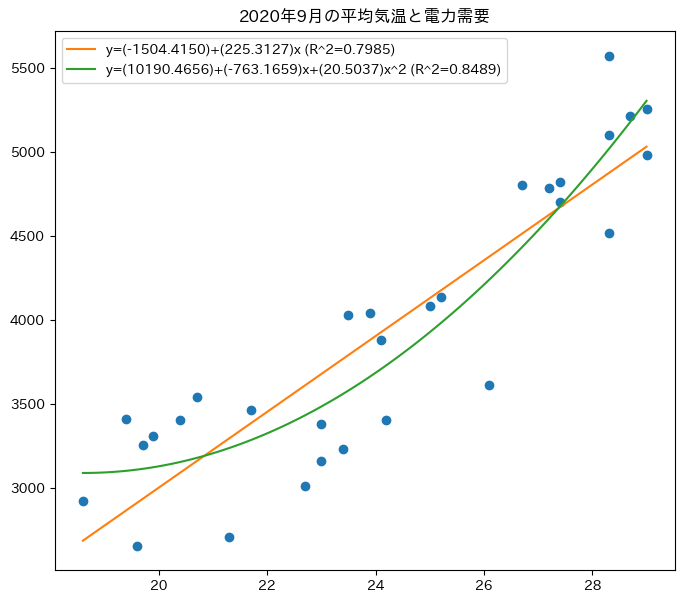

## 2020年10月の平均気温と電力需要の単回帰・多項式回帰分析
y=(2954.6541)+(13.6517)x (R^2=0.0170)
y=(2327.6922)+(86.6310)x+(-2.0672)x^2 (R^2=0.0194)


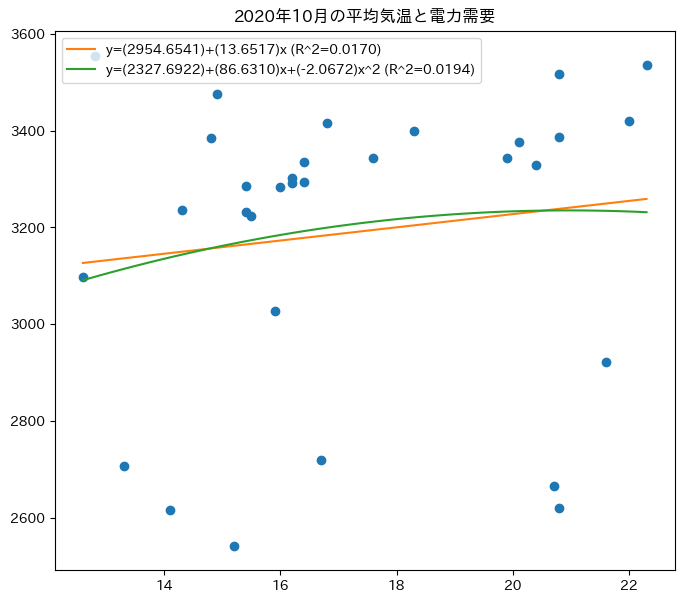

## 2020年11月の平均気温と電力需要の単回帰・多項式回帰分析
y=(3854.7049)+(-51.9766)x (R^2=0.1337)
y=(3995.3738)+(-74.7517)x+(0.8901)x^2 (R^2=0.1339)


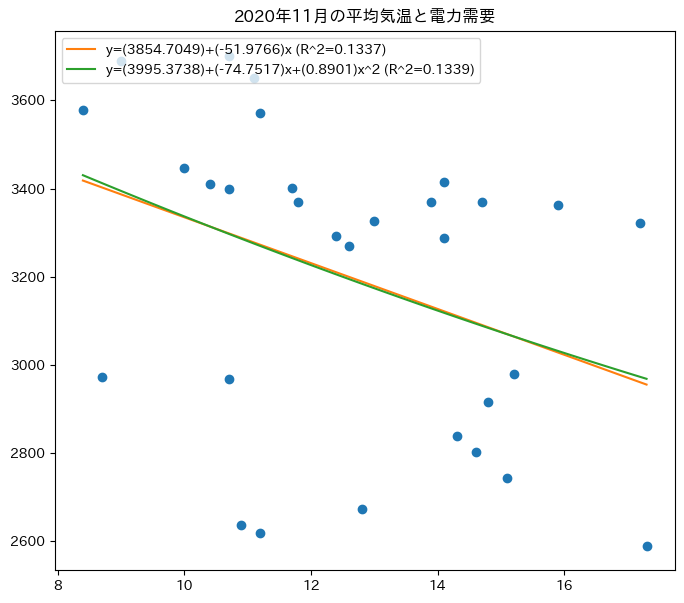

## 2020年12月の平均気温と電力需要の単回帰・多項式回帰分析
y=(3965.0919)+(-38.3943)x (R^2=0.0435)
y=(3696.8607)+(59.5957)x+(-7.8174)x^2 (R^2=0.0539)


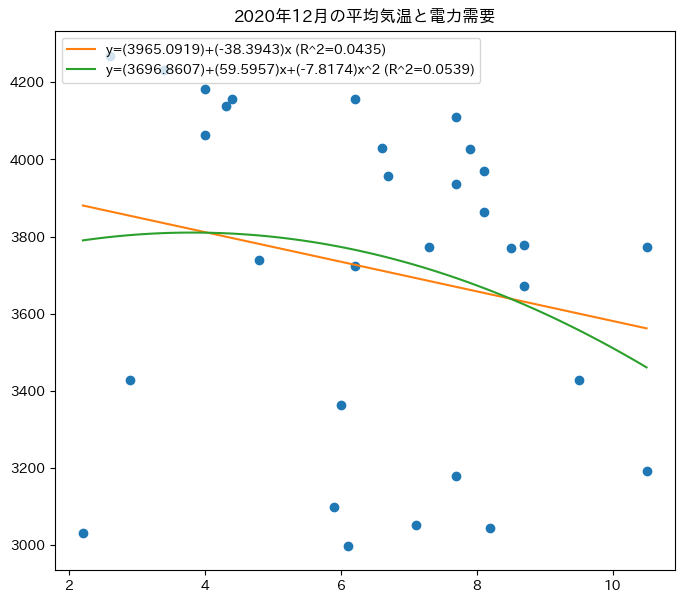

r1_min 2020/5 0.005035689975652624
r1_max 2020/9 0.7984949390143861
r2_min 2020/10 0.019416780597337535
r2_max 2020/9 0.8488792381988916


In [9]:
for _temp in ['最高気温', '最低気温', '平均気温']:
    # 決定係数の最大・最小を調査
    r1_min = 1
    r1_min_yearmonth = 0
    r1_max = 0
    r1_max_yearmonth = 0
    r2_min = 1
    r2_min_yearmonth = ''
    r2_max = 0
    r2_max_yearmonth = ''

    for _month in range(1,13,1):
        r1, r2 = temp_power_r(weather_df, power_df, 2020, _month, _temp)
        
        if r1 < r1_min:
            r1_min = r1
            r1_min_yearmonth = f'2020/{_month}'
        if r2 < r2_min:
            r2_min = r2
            r2_min_yearmonth = f'2020/{_month}'
        if r1 > r1_max:
            r1_max = r1
            r1_max_yearmonth = f'2020/{_month}'
        if r2 > r2_max:
            r2_max = r2
            r2_max_yearmonth = f'2020/{_month}'

    print('r1_min', r1_min_yearmonth, r1_min)
    print('r1_max', r1_max_yearmonth, r1_max)
    print('r2_min', r2_min_yearmonth, r2_min)
    print('r2_max', r2_max_yearmonth, r2_max)

In [10]:
def temp_power_r_year(weather_df, power_df, year, _temp):
    print(f'## {year}年の{_temp}と電力需要の単回帰・多項式回帰分析')

    x = weather_df[(datetime.datetime(year,1,1) <= weather_df['年月日']) 
            & (weather_df['年月日'] < datetime.datetime(year+1,1,1))][[_temp]]
    y = power_df[(datetime.datetime(year,1,1) <= power_df['DATETIME'])
            & (power_df['DATETIME'] < datetime.datetime(year+1,1,1))
            & (power_df['TIME'] == '14:00')][['power']]
    pf = PolynomialFeatures(degree=2)
    x2 = pf.fit_transform(x)
    
    # 単回帰分析を実施して結果を出力
    model_lr = LinearRegression()
    model_lr.fit(x, y)
    print('y= %.6f + %.6fx (寄与率 R^2: %.6f)' 
        % (model_lr.intercept_, model_lr.coef_, model_lr.score(x, y)))

    # 多項式回帰分析を実施して結果を出力
    model_pr = LinearRegression()
    model_pr.fit(x2, y)
    print('y= %.6f + %.6fx + %.6fx^2 (寄与率 R^2: %.6f)' 
        % (model_pr.intercept_, model_pr.coef_[0][1], model_pr.coef_[0][2], model_pr.score(x2, y)))

    # 元データの散布図を作成
    fig = plt.figure(figsize=(8, 7))
    ax1 = fig.add_subplot(111)
    ax1.plot(x, y, 'o')

    # 求めた単回帰分析の結果(直線)を描画
    x_linspace = pd.DataFrame(np.linspace(x.min(), x.max(), 100), columns=[_temp])
    ax1.plot(x_linspace, model_lr.predict(x_linspace))

    # 多項式回帰分析の結果(曲線)を描画
    x_linspace_pf = pf.fit_transform(x_linspace)
    y_pred = model_pr.predict(x_linspace_pf)
    ax1.plot(x_linspace, y_pred)
    ax1.set_title(f'{year}年の{_temp}と電力需要')
    plt.show()

    return model_lr.score(x, y), model_pr.score(x2, y)

## 2020年の平均気温と電力需要の単回帰・多項式回帰分析
y= 3074.707505 + 28.320114x (寄与率 R^2: 0.116956)
y= 4798.650339 + -240.082546x + 8.000520x^2 (寄与率 R^2: 0.604744)


C:\Users\khiramatsu\AppData\Local\Temp\ipykernel_1428\2447271402.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('y= %.6f + %.6fx (寄与率 R^2: %.6f)'
C:\Users\khiramatsu\AppData\Local\Temp\ipykernel_1428\2447271402.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('y= %.6f + %.6fx + %.6fx^2 (寄与率 R^2: %.6f)'


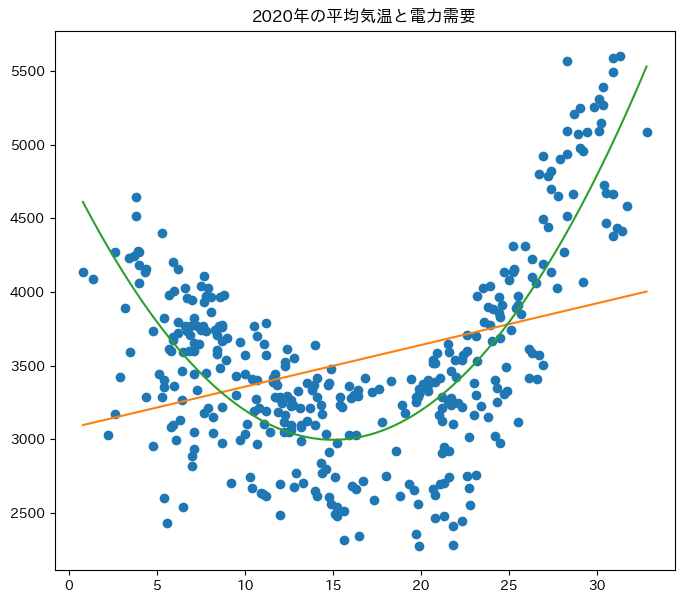

## 2020年の最高気温と電力需要の単回帰・多項式回帰分析
y= 2953.829190 + 27.107423x (寄与率 R^2: 0.109962)
y= 5812.728129 + -270.314009x + 6.674358x^2 (寄与率 R^2: 0.558706)


C:\Users\khiramatsu\AppData\Local\Temp\ipykernel_1428\2447271402.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('y= %.6f + %.6fx (寄与率 R^2: %.6f)'
C:\Users\khiramatsu\AppData\Local\Temp\ipykernel_1428\2447271402.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('y= %.6f + %.6fx + %.6fx^2 (寄与率 R^2: %.6f)'


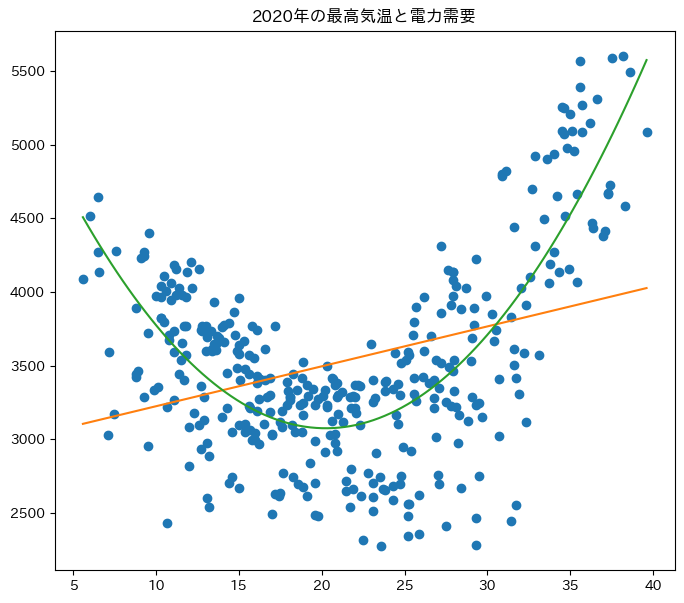

## 2020年の最低気温と電力需要の単回帰・多項式回帰分析
y= 3211.765219 + 27.257596x (寄与率 R^2: 0.122633)
y= 3747.714602 + -145.542713x + 7.042327x^2 (寄与率 R^2: 0.538163)


C:\Users\khiramatsu\AppData\Local\Temp\ipykernel_1428\2447271402.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('y= %.6f + %.6fx (寄与率 R^2: %.6f)'
C:\Users\khiramatsu\AppData\Local\Temp\ipykernel_1428\2447271402.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('y= %.6f + %.6fx + %.6fx^2 (寄与率 R^2: %.6f)'


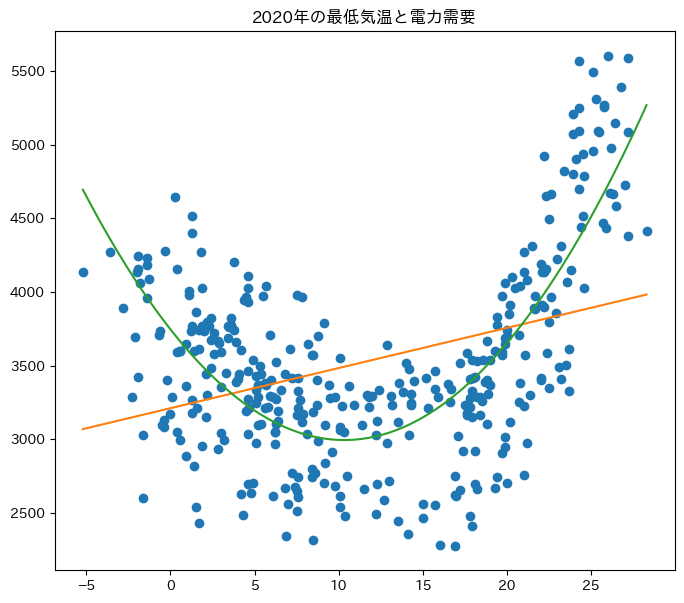

In [11]:
for _temp in ['平均気温', '最高気温', '最低気温']:
    temp_power_r_year(weather_df, power_df, 2020, _temp)